In [57]:
from pathlib import Path
import pickle
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import magnetdesigner
import magnetoptimiser

In [58]:
# magnetoptimizer_path = Path().resolve().parent.parent.parent / "magnetoptimiser"
# model_dir_path = magnetoptimizer_path / "src" / "magnetoptimiser" / "models_trained" / "dipole_hshaped" / "v001"

In [59]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x

In [60]:
trainer = magnetoptimiser.trainers.DefaultTrainer_Dipole_Hshape
trainer.set_device("cpu")
model = trainer.model
scaler_x = trainer.scaler_x
scaler_y = trainer.scaler_y

In [61]:
# device = torch.device('cpu')
# model = NeuralNetwork(40, 256, 33)
# model.load_state_dict(torch.load(model_dir_path / "model_trained.pth",device))
# scaler_x = pickle.load(open(model_dir_path / "scaler_x.pkl","rb"))
# scaler_y = pickle.load(open(model_dir_path / "scaler_y.pkl","rb"))

In [62]:
# df = pd.read_csv(magnetoptimizer_path / "src" / "magnetoptimiser"/ "data" / "hdipole_gfr_dataset_00k-30k.csv")
# index_dict = {col:i for i,col in enumerate(list(df.columns)[40:])}
index_dict = magnetoptimiser.datasets.Dipole_H.input_columns + magnetoptimiser.datasets.Dipole_H.target_columns
index_dict = {col:i for i,col in enumerate(index_dict)}
index_dict

{'gfr_x': 0,
 'gfr_y': 1,
 'gfr_margin': 2,
 'maxCurrentDensity': 3,
 'fieldTolerance': 4,
 'aper_x': 5,
 'aper_y': 6,
 'aper_x_poleoverhang': 7,
 'aper_y_distFromCoil': 8,
 'aper_x_tapering': 9,
 'aper_x_taperingstop': 10,
 'B_design': 11,
 'B_design_margin': 12,
 'B_real': 13,
 'coil_width': 14,
 'coil_height': 15,
 'yoke_x': 16,
 'yoke_y': 17,
 'maxBmaterial': 18,
 'fillfactor': 19,
 'windings': 20,
 'w': 21,
 'w_leg': 22,
 'totalCurrent': 23,
 'totalCurrentMax': 24,
 'coilAreaTotal': 25,
 'coilWeightTotal': 26,
 'coilVolumeTotal': 27,
 'length': 28,
 'yokeAreaTotal': 29,
 'yokeWeightTotal': 30,
 'yokeVolumeTotal': 31,
 'shims_False': 32,
 'shape_H': 33,
 'material_coil_Copper': 34,
 'material_yoke_Pure Iron': 35,
 'symmetry_reflectxydipole': 36,
 'coolingRequirementMax_Liquid Nitrogen': 37,
 'coolingRequirementMax_None': 38,
 'coolingRequirementMax_Water': 39,
 'B0': 40,
 'gfr_x_1e-7': 41,
 'gfr_x_2e-7': 42,
 'gfr_x_5e-7': 43,
 'gfr_x_1e-6': 44,
 'gfr_x_2e-6': 45,
 'gfr_x_5e-6': 46

In [63]:
# with pd.option_context('display.max_columns', None): 
#     display(df[1:2])


In [64]:
def map_to_input(input, mtype="H"):
    input = input.detach().numpy()
    field, fq, aper_x, aper_y, maxCurrentDensity, field_real = input[0,0], input[0,1], input[0,2], input[0,3], input[0,4], input[0,5]
    magnet = magnetdesigner.designer.get_Dipole(field, fq, 5000, 1e-3, 1e-3, aper_x=aper_x, aper_y=aper_y, maxCurrentDensity=maxCurrentDensity, B_real=field_real, shape=mtype)

    inputcolumns = ['gfr_x', 'gfr_y', 'gfr_margin', 'maxCurrentDensity', 'fieldTolerance', 'aper_x', 'aper_y', 'aper_x_poleoverhang', 'aper_y_distFromCoil', 'aper_x_tapering', 'aper_x_taperingstop', 'B_design', 'B_design_margin', 'B_real', 'coil_width', 'coil_height', 'yoke_x', 'yoke_y', 'maxBmaterial', 'fillfactor', 'windings', 'w', 'w_leg', 'totalCurrent', 'totalCurrentMax', 'coilAreaTotal', 'coilWeightTotal', 'coilVolumeTotal', 'length', 'yokeAreaTotal', 'yokeWeightTotal', 'yokeVolumeTotal', 'shims_False', 'shape_H', 'material_coil_Copper', 'material_yoke_Pure Iron', 'symmetry_reflectxydipole', 'coolingRequirementMax_Liquid Nitrogen', 'coolingRequirementMax_None', 'coolingRequirementMax_Water']
    # prop dict
    prop = magnet.get_properties()
    prop = pd.DataFrame(prop, index=[0])
    prop = pd.get_dummies(prop, columns=['shims', 'shape', 'material_coil', 'material_yoke', 'symmetry', 'coolingRequirementMax'])
    # check if 'coolingRequirementMax_Liquid Nitrogen', 'coolingRequirementMax_Water', 'coolingRequirementMax_None' are in the columns
    if 'coolingRequirementMax_Liquid Nitrogen' not in prop.columns:
        prop['coolingRequirementMax_Liquid Nitrogen'] = 0
    if 'coolingRequirementMax_Water' not in prop.columns:
        prop['coolingRequirementMax_Water'] = 0
    if 'coolingRequirementMax_None' not in prop.columns:
        prop['coolingRequirementMax_None'] = 0
    prop = prop.drop(columns=['name'])
    prop = prop[inputcolumns]
    prop = prop.values.astype(float)
    prop = torch.tensor(prop, dtype=torch.float32)
    return prop

In [65]:
tuple_of_interest = (index_dict["B0"]-40,index_dict["gfr_x_5e-3"]-40,index_dict["gfr_x_5e-3"]-40)

# bounds for field, fq, aper_x, aper_y, maxCurrentDensity, field_real
bounds = [(0.01, 2.0), (0.01, 0.3), (0.01, 0.3), (1e-4, 1e-2), (2.0, 10.0), (0.001, 2.4)]

dummy_input = torch.tensor([[2.0, 1e-2, 0.3, 0.3, 10.0, 1.0]], requires_grad=True)

optim = torch.optim.Adam([dummy_input])

target = torch.zeros(1,33)
target[0,tuple_of_interest[0]] = 0.079589
target[0,tuple_of_interest[1]] = 0.053487
target[0,tuple_of_interest[2]] = 0.01

target = torch.tensor(scaler_y.transform(target)).float()

def create_loss_function(tuple_of_interest):
    mask = torch.zeros(1,33)
    for i in tuple_of_interest:
        mask[0,i] = 1
    mse = torch.nn.MSELoss()
    def instanciated_loss_function(x,y):
        return mse(x*mask,y*mask)
    return instanciated_loss_function

loss_fun = create_loss_function(tuple_of_interest)
loss_hist= []

model.train()
epochs = 10000
for e in range(epochs):
    print(f"epoch {e}")
    pred = trainer.predict(map_to_input(dummy_input), True)
    pred = torch.tensor(pred, requires_grad=True)
    optim.zero_grad()
    loss = loss_fun(pred, target)
    loss_hist.append(loss.detach().item())
    loss.backward()
    optim.step()
    #projection
    with torch.no_grad():
        # clamp can have different lower and upper bounds for different columns : https://stackoverflow.com/questions/54738045/column-dependent-bounds-in-torch-clamp
        dummy_input.clamp_(min=0)

output = scaler_x.inverse_transform(map_to_input(dummy_input).detach().numpy())[0]
print(f"final loss: {loss.item()}")
print(output)


epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


In [66]:
# readable = [f"{val.item():.3f}" for val in output]
# readable_df = pd.DataFrame([readable],columns=list(df.columns)[:40])
# with pd.option_context('display.max_columns', None): 
#     display(readable_df)

<Axes: >

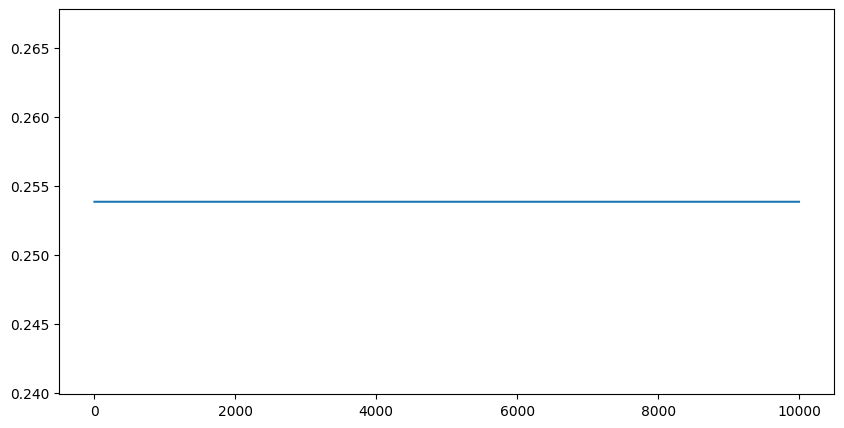

In [67]:
fig,axes = plt.subplots(1,1,figsize=(10,5))
idxs = np.arange(len(loss_hist))
sns.lineplot(ax=axes,x=idxs,y=loss_hist)